In [1]:
import sys
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from dataclasses import dataclass, field
from typing import List, Optional
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from glob import glob
import random
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

Define Mediapipe

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [3]:
# 定义需要显示的特定面部关键点编号
selected_indices = [
    419, 290, 303, 242, 56, 155, 221, 226, 387, 362, 385, 310, 295, 340, 0, 37, 39, 40, 178, 146, 90, 72, 
    448, 380, 274, 398, 87, 98, 64, 324, 222, 1, 13, 22, 159, 145, 157, 89, 
    312, 462, 259, 63, 66, 112, 461, 463, 348, 62, 308, 119, 269, 78, 16, 65, 144, 163, 
    384, 229, 84, 321, 325, 466, 403, 182, 232, 219, 141, 249, 196, 320, 95, 
    304, 77, 272, 224, 239, 268, 316, 405, 86, 186, 
    63, 296, 334, 53, 195, 66, 107, 52, 65
]

# 定义数据类来存储每个关键点的坐标
@dataclass
class Landmark:
    x: float
    y: float
    z: float

# 定义 CustomResults 数据类
@dataclass
class CustomResults:
    face_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    pose_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    left_hand_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None
    right_hand_landmarks: Optional[landmark_pb2.NormalizedLandmarkList] = None

# 提取并过滤面部关键点并生成 NormalizedLandmarkList
def create_filtered_face_landmarks(landmarks, indices):
    if not landmarks:
        return None
    filtered_landmarks = [landmarks[idx] for idx in indices]
    return landmark_pb2.NormalizedLandmarkList(landmark=filtered_landmarks)

In [4]:
# 使用标准的 MediaPipe 绘图方式来绘制关键点（无连接线）
def draw_landmarks(image, custom_results):
    h, w, _ = image.shape
    
    # 绘制面部关键点（不包含连接线）
    if custom_results.face_landmarks:
        for idx, landmark in zip(selected_indices, custom_results.face_landmarks.landmark):
            x, y = int(landmark.x * w), int(landmark.y * h)
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  
            cv2.putText(image, str(idx), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)

    # 绘制姿势关键点
    if custom_results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(88, 22, 88), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(66, 22, 66), thickness=2, circle_radius=2)
        )

    # 绘制左手关键点
    if custom_results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(100, 22, 200), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(100, 22, 200), thickness=2, circle_radius=2)
        )

    # 绘制右手关键点
    if custom_results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, custom_results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 90, 0), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(0, 90, 0), thickness=2, circle_radius=2)
        )

In [5]:
# # 使用 MediaPipe Holistic 模型
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     cap = cv2.VideoCapture(0)

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             print("无法读取视频帧")
#             break

#         # 转换颜色空间
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         results = holistic.process(frame_rgb)

#         # 创建自定义的结果结构
#         custom_results = CustomResults(
#             face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
#             pose_landmarks=results.pose_landmarks,
#             left_hand_landmarks=results.left_hand_landmarks,
#             right_hand_landmarks=results.right_hand_landmarks
#         )

#         # 绘制关键点
#         draw_landmarks(frame, custom_results)

#         # 显示结果
#         cv2.imshow('Custom Results Feed', frame)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()


In [6]:
# if custom_results.face_landmarks:
#     print(f"面部关键点数量: {len(custom_results.face_landmarks.landmark)}")
# if custom_results.left_hand_landmarks:
#     print(f"左手关键点数量: {len(custom_results.left_hand_landmarks.landmark)}")
# if custom_results.right_hand_landmarks:
#     print(f"右手关键点数量: {len(custom_results.right_hand_landmarks.landmark)}")
# if custom_results.pose_landmarks:
#     print(f"姿势关键点数量: {len(custom_results.pose_landmarks.landmark)}")

In [7]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract keypoints

In [8]:
def extract_keypoints(custom_results):
    face= np.array([[lm.x, lm.y, lm.z] for lm in custom_results.face_landmarks.landmark]).flatten() \
                     if custom_results.face_landmarks else np.zeros(90 * 3)  
    pose= np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in custom_results.pose_landmarks.landmark]).flatten() \
                     if custom_results.pose_landmarks else np.zeros(33 * 4)  
    lh = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.left_hand_landmarks.landmark]).flatten() \
                          if custom_results.left_hand_landmarks else np.zeros(21 * 3) 

    rh = np.array([[lm.x, lm.y, lm.z] for lm in custom_results.right_hand_landmarks.landmark]).flatten() \
                           if custom_results.right_hand_landmarks else np.zeros(21 * 3) 

    all_landmarks = np.concatenate([face,pose,lh,rh])
    return all_landmarks


In [9]:
# custom_results_numpy = extract_keypoints(custom_results)
# print("Flattened shape for LSTM input:", custom_results_numpy.shape)

In [10]:
# result_test = extract_keypoints(custom_results)
# result_test

Collect data

In [11]:
def record_action(root_folder, action_name, user_name, repeat_count=5, record_duration=3.5, countdown_duration=2, frame_width=1920, frame_height=1080, fps=30):
  
    # 在根文件夹路径下创建 custom_data 文件夹及动作子文件夹
    action_folder = os.path.join(root_folder, 'custom_data', action_name)
    os.makedirs(action_folder, exist_ok=True)

    # 初始化摄像头
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)
    frame_count = int(fps * record_duration)

    quit_flag = False 

    for count in range(1, repeat_count + 1):
        if quit_flag:
            break 

        # 文件名格式: 动作_计数_用户名.mp4
        video_filename = f"{action_name}_{count}_{user_name}.mp4"
        video_filepath = os.path.join(action_folder, video_filename)
        out = cv2.VideoWriter(video_filepath, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

        print(f"准备录制 {action_name} 动作，计数：{count}，保存到：{video_filepath}")

        # 倒计时黑屏
        for i in range(countdown_duration, 0, -1):
            black_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
            cv2.putText(black_frame, f"Get Ready: {i}", (frame_width // 2 - 100, frame_height // 2), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4)
            cv2.putText(black_frame, f"{action_name} | Count: {count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imshow('Recording', black_frame)
            if cv2.waitKey(1000) & 0xFF == ord('q'):
                quit_flag = True  # 如果按下 'q' 键，设置退出标志
                break

        if quit_flag:
            break  # 跳出当前录制会话

        print("开始录制...")
        for _ in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                print("无法捕获视频帧。")
                break
            # 绘制绿色边框
            thickness = 10
            cv2.rectangle(frame, (0, 0), (frame_width, frame_height), (0, 255, 0), thickness)
            cv2.putText(frame, f"{action_name} | Count: {count}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            out.write(frame)
            # 实时显示画面
            cv2.imshow('Recording', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):  # 按 'q' 键可提前停止录制
                quit_flag = True
                break

        # 释放当前视频文件
        out.release()
        print(f"视频已保存至：{video_filepath}")

    # 释放摄像头和窗口资源
    cap.release()
    cv2.destroyAllWindows()


In [12]:
# 定义词语和标签映射
words = ['hello',  'I or me', 'father', 'mother','see u later']
label_map = {label: num for num, label in enumerate(words)}
DATA_PATH = 'I:/Ece496/custom_data'
no_sequences = 30  # 每个词语的视频数量
sequence_length = int(30 * 3.5)  # 每个视频的帧数



DATA_PATH = "I:\\Ece496\\custom_data"
PROCESSED_VIDEOS_PATH = os.path.join(DATA_PATH, "processed_videos.txt")
SEQUENCE_COUNTER_PATH = os.path.join(DATA_PATH, "sequence_counter.json")

# 加载之前保存的关键点数据
if os.path.exists(os.path.join(DATA_PATH, "X.npy")) and os.path.exists(os.path.join(DATA_PATH, "y.npy")):
    X = np.load(os.path.join(DATA_PATH, "X.npy"))
    y = np.load(os.path.join(DATA_PATH, "y.npy"))
    sequences = list(X)  # 转为列表，以便后续可以追加新数据
    labels = list(y)  # 转为列表
else:
    sequences = []
    labels = []

# 加载已处理的视频路径
if os.path.exists(PROCESSED_VIDEOS_PATH):
    with open(PROCESSED_VIDEOS_PATH, 'r') as f:
        processed_videos = set(line.strip() for line in f)
else:
    processed_videos = set()
    
# 加载 sequence_counter 状态
if os.path.exists(SEQUENCE_COUNTER_PATH):
    with open(SEQUENCE_COUNTER_PATH, 'r') as f:
        sequence_counter = json.load(f)
else:
    sequence_counter = {word: 0 for word in words}  # 初始化计数器


for word in words:
    word_path = os.path.join(DATA_PATH, word)
    video_files = glob(os.path.join(word_path, f"{word}_*.mp4"))
    
    for video_file in video_files:
        if video_file in processed_videos:
            print(f"Skipping already processed video: {video_file}")
            continue

        # 每次处理一个新的文件，就增加该 word 的计数
        sequence_counter[word] += 1
        sequence = sequence_counter[word]  # 获取当前 word 的 sequence 编号

        print(f"Processing video: {video_file}, sequence: {sequence}")

        # 处理视频文件
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            print(f"Cannot open video file: {video_file}")
            continue
        
        window = []

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            frame_num = 0
            while frame_num < sequence_length:
                ret, frame = cap.read()
                if not ret:
                    print(f"Failed to read frame from {video_file}")
                    break
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)

                custom_results = CustomResults(
                    face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
                    pose_landmarks=results.pose_landmarks,
                    left_hand_landmarks=results.left_hand_landmarks,
                    right_hand_landmarks=results.right_hand_landmarks
                )
                
                keypoints = extract_keypoints(custom_results)
                window.append(keypoints)
                
                frame_num += 1

        cap.release()

        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[word])
            processed_videos.add(video_file)
            print(f"Added sequence for word '{word}', sequence {sequence}")

# 保存处理过的视频路径到 txt 文件
with open(PROCESSED_VIDEOS_PATH, 'w') as f:
    for video_path in processed_videos:
        f.write(f"{video_path}\n")

# 转换 `sequences` 和 `labels` 为 NumPy 数组后保存
X = np.array(sequences)
y = np.array(labels)
np.save(os.path.join(DATA_PATH, "X.npy"), X)
np.save(os.path.join(DATA_PATH, "y.npy"), y)

print("Total sequences:", len(sequences))
print("X 的形状:", X.shape)
print("y 的形状:", y.shape)

In [13]:
# 初始化路径
DATA_PATH = "I:\\Ece496\\custom_data"
PROCESSED_VIDEOS_PATH = os.path.join(DATA_PATH, "processed_videos.txt")
SEQUENCE_COUNTER_PATH = os.path.join(DATA_PATH, "sequence_counter.json")

# 加载之前保存的关键点数据
if os.path.exists(os.path.join(DATA_PATH, "X.npy")) and os.path.exists(os.path.join(DATA_PATH, "y.npy")):
    X = np.load(os.path.join(DATA_PATH, "X.npy"))
    y = np.load(os.path.join(DATA_PATH, "y.npy"))
    sequences = list(X)  # 转为列表，以便后续可以追加新数据
    labels = list(y)  # 转为列表
else:
    sequences = []
    labels = []

# 加载已处理的视频路径
if os.path.exists(PROCESSED_VIDEOS_PATH):
    with open(PROCESSED_VIDEOS_PATH, 'r') as f:
        processed_videos = set(line.strip() for line in f)
else:
    processed_videos = set()
    
# 加载 sequence_counter 状态
if os.path.exists(SEQUENCE_COUNTER_PATH):
    with open(SEQUENCE_COUNTER_PATH, 'r') as f:
        sequence_counter = json.load(f)
else:
    sequence_counter = {word: 0 for word in words}  # 初始化计数器

for word in words:
    word_path = os.path.join(DATA_PATH, word)
    video_files = glob(os.path.join(word_path, f"{word}_*.mp4"))
    
    for video_file in video_files:
        if video_file in processed_videos:
            print(f"Skipping already processed video: {video_file}")
            continue

        # 每次处理一个新的文件，就增加该 word 的计数
        sequence_counter[word] += 1
        sequence = sequence_counter[word]  # 获取当前 word 的 sequence 编号

        print(f"Processing video: {video_file}, sequence: {sequence}")

        # 处理视频文件
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            print(f"Cannot open video file: {video_file}")
            continue
        
        window = []

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            frame_num = 0
            while frame_num < sequence_length:
                ret, frame = cap.read()
                if not ret:
                    print(f"Failed to read frame from {video_file}")
                    break
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)

                custom_results = CustomResults(
                    face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
                    pose_landmarks=results.pose_landmarks,
                    left_hand_landmarks=results.left_hand_landmarks,
                    right_hand_landmarks=results.right_hand_landmarks
                )
                
                keypoints = extract_keypoints(custom_results)
                window.append(keypoints)
                
                frame_num += 1

        cap.release()

        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[word])
            processed_videos.add(video_file)
            print(f"Added sequence for word '{word}', sequence {sequence}")

            # 每次成功处理一个视频后，保存 sequence_counter 状态
            with open(SEQUENCE_COUNTER_PATH, 'w') as f:
                json.dump(sequence_counter, f)

# 保存处理过的视频路径到 txt 文件
with open(PROCESSED_VIDEOS_PATH, 'w') as f:
    for video_path in processed_videos:
        f.write(f"{video_path}\n")

# 转换 `sequences` 和 `labels` 为 NumPy 数组后保存
X = np.array(sequences)
y = np.array(labels)
np.save(os.path.join(DATA_PATH, "X.npy"), X)
np.save(os.path.join(DATA_PATH, "y.npy"), y)

print("Total sequences:", len(sequences))
print("X 的形状:", X.shape)
print("y 的形状:", y.shape)


Skipping already processed video: I:\Ece496\custom_data\hello\hello_1_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_2_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_3_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_4_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_5_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_6_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_7_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_8_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_9_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_10_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_11_Bill.mp4
Skipping already processed video: I:\Ece496\custom_data\hello\hello_12_Bill.mp4
Skipping already processed video: I:\Ece496\custo

In [14]:
print("Total sequences:", len(sequences))
print("X 的形状:", X.shape)
print("y 的形状:", y.shape)

Total sequences: 150
X 的形状: (150, 105, 528)
y 的形状: (150,)


Show processing in real time

for word in words:
    word_path = os.path.join(DATA_PATH, word)
    video_files = glob(os.path.join(word_path, f"{word}_*.mp4"))
    
    print(f"Found {len(video_files)} videos for word '{word}'")

    for video_file in video_files:
        filename = os.path.basename(video_file)
        sequence = int(filename.split('_')[1].split('.')[0])
        
        print("Processing video:", video_file)
        
        cap = cv2.VideoCapture(video_file)
        
        if not cap.isOpened():
            print(f"Cannot open video file: {video_file}")
            continue
        
        window = []

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            frame_num = 0
            while frame_num < sequence_length:
                ret, frame = cap.read()
                if not ret:
                    print(f"Failed to read frame from {video_file}")
                    break
                
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)

                # 创建 custom_results
                custom_results = CustomResults(
                    face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
                    pose_landmarks=results.pose_landmarks,
                    left_hand_landmarks=results.left_hand_landmarks,
                    right_hand_landmarks=results.right_hand_landmarks
                )
                
                # 提取关键点并存储
                keypoints = extract_keypoints(custom_results)
                window.append(keypoints)
                
                # 调用自定义的绘图函数
                draw_landmarks(frame, custom_results)
                
                # 显示当前帧
                cv2.imshow("Frame with landmarks", frame)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                
                frame_num += 1
        
        cap.release()
        cv2.destroyAllWindows()
        
        # 检查帧数是否满足要求
        if len(window) != sequence_length:
            print(f"Video {video_file} has insufficient frames: {len(window)} (required: {sequence_length})")
        else:
            sequences.append(window)
            labels.append(label_map[word])

# 转换为 NumPy 数组
X = np.array(sequences)
y = np.array(labels)

print("X 的形状:", X.shape)
print("y 的形状:", y.shape)


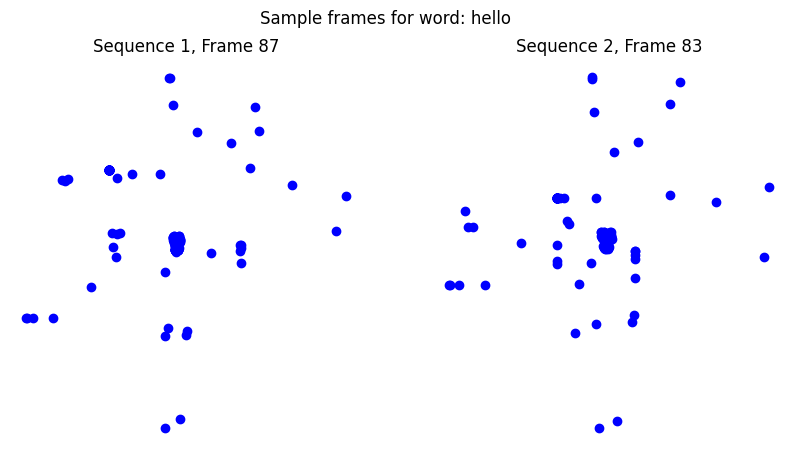

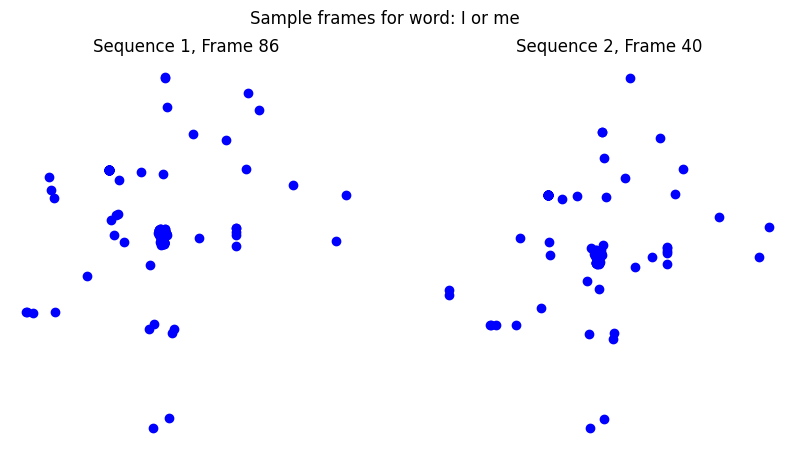

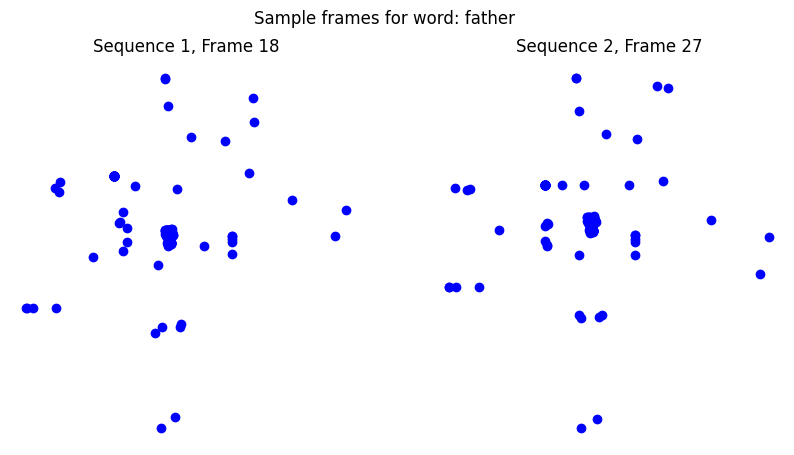

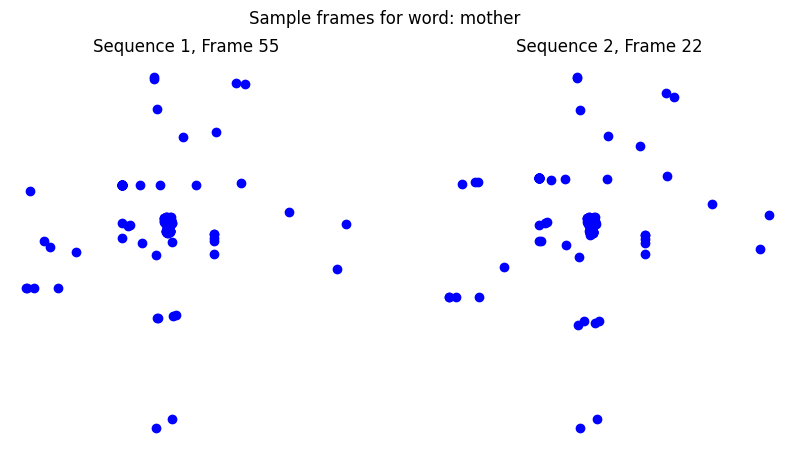

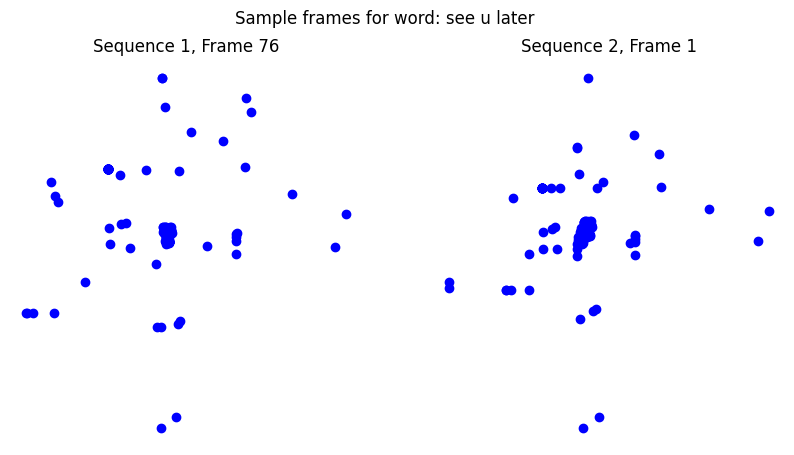

In [15]:
for word in words:
    word_index = label_map[word]
    word_sequences = [X[i] for i in range(len(y)) if y[i] == word_index]
    
    # 随机选择两段序列
    if len(word_sequences) >= 2:
        random_sequences = random.sample(word_sequences, 2)
    else:
        random_sequences = word_sequences  # 若序列少于两段，全部展示

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Sample frames for word: {word}")
    
    for idx, sequence in enumerate(random_sequences):
        frame_idx = random.randint(0, sequence_length - 1)  # 随机选取一帧
        keypoints = sequence[frame_idx]  # 获取关键点

        # 可视化关键点
        axs[idx].scatter(keypoints[0::3], keypoints[1::3], c='blue')  # x 和 y 轴关键点
        axs[idx].set_title(f"Sequence {idx+1}, Frame {frame_idx+1}")
        axs[idx].invert_yaxis()  # 反转 y 轴，符合图像坐标系
        axs[idx].axis("off")

    plt.show()

In [16]:
y = to_categorical(labels, num_classes=len(words)).astype(int)

In [17]:
y


array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0,

Preprocess data

In [18]:
try:
    center_idx_in_data = selected_indices.index(195)
    print(f"195 在 selected_indices 中的位置: {center_idx_in_data}")
except ValueError:
    print("195 不在 selected_indices 中")

195 在 selected_indices 中的位置: 85


In [19]:
def normalize_xy(keypoints):
    # 假设 keypoints 是三维数组，形状为 (视频数, 帧数, 关键点数*3)
    x_vals = keypoints[..., ::3]  # 提取所有 x 坐标
    y_vals = keypoints[..., 1::3]  # 提取所有 y 坐标

    # 计算 x 和 y 的最大值与最小值，进行归一化
    x_max, x_min = x_vals.max(), x_vals.min()
    y_max, y_min = y_vals.max(), y_vals.min()

    keypoints[..., ::3] = (x_vals - x_min) / (x_max - x_min + 1e-6)
    keypoints[..., 1::3] = (y_vals - y_min) / (y_max - y_min + 1e-6)

    return keypoints

X_normalized = normalize_xy(X.copy())


In [20]:
def centralize_keypoints(keypoints, center_idx=85):

    # 提取中心关键点的坐标（X, Y, Z）
    center_x = keypoints[..., center_idx*3]
    center_y = keypoints[..., center_idx*3 + 1]
    center_z = keypoints[..., center_idx*3 + 2]

    # 对每个关键点的 X、Y 和 Z 进行偏移，使其相对于中心关键点
    keypoints[..., ::3] -= center_x[..., np.newaxis]  # X 坐标中心化
    keypoints[..., 1::3] -= center_y[..., np.newaxis]  # Y 坐标中心化
    keypoints[..., 2::3] -= center_z[..., np.newaxis]  # Z 坐标中心化

    return keypoints


In [21]:
X_centralized = centralize_keypoints(X.copy(), center_idx=85)
X_normalized = normalize_xy(X_centralized.copy())
#y = to_categorical(labels, num_classes=len(words)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LSTM without velocity

In [22]:
model = Sequential()

# 使用 'tanh' 激活函数以便利用 cuDNN 优化
model.add(LSTM(256, return_sequences=True, activation='tanh', input_shape=(105, 528)))
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='tanh'))  # 在 Dense 层之前的最后一个 LSTM 层不需要 return_sequences

# 输出层
model.add(Dense(len(words), activation='softmax'))  # `words` 是类别列表

# 定义 TensorBoard 和 ReduceLROnPlateau 回调
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 将回调函数加入训练中
callbacks = [tb_callback, reduce_lr]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 105, 256)          803840    
                                                                 
 dropout (Dropout)           (None, 105, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 105, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 105, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 105, 64)           49408     
                                                                 
 dropout_2 (Dropout)         (None, 105, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                1

: 

In [ ]:
history = model.fit(X_train, y_train, epochs=250, callbacks=[tb_callback])

Epoch 1/250


In [ ]:
mp_holistic = mp.solutions.holistic
actions = words
# 动作类别
actions = ['hello', 'I or me', 'father', 'mother', 'see u later']  # 替换为您的类别

model = Sequential()
model.add(LSTM(256, return_sequences=True, activation='tanh', input_shape=(105, 528)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(len(actions), activation='softmax'))
model.load_weights('C:\\Users\\Bill\\Desktop\\Ece496\\data\\model_weights.h5')  # 替换为您保存权重的路径

# 实时动作识别变量
sequence = []
sentence = []
threshold = 0.8
sequence_length = 105  # 与训练时保持一致

# 实时动作识别
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # 颜色转换和处理
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        # 创建自定义结果
        custom_results = CustomResults(
            face_landmarks=create_filtered_face_landmarks(results.face_landmarks.landmark, selected_indices) if results.face_landmarks else None,
            pose_landmarks=results.pose_landmarks,
            left_hand_landmarks=results.left_hand_landmarks,
            right_hand_landmarks=results.right_hand_landmarks
        )

        # 提取关键点
        keypoints = extract_keypoints(custom_results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]  # 保持序列长度为105

        # 进行预测
        predicted_action = ""
        if len(sequence) == sequence_length:
            prediction = model.predict(np.expand_dims(sequence, axis=0))[0]
            confidence = np.max(prediction)
            predicted_action = actions[np.argmax(prediction)] if confidence > threshold else ""

            # 仅在置信度高于阈值时更新句子
            if confidence > threshold:
                if len(sentence) == 0 or predicted_action != sentence[-1]:
                    sentence.append(predicted_action)

            # 控制句子的最大长度
            if len(sentence) > 5:
                sentence = sentence[-5:]

        # 在帧上显示预测结果
        cv2.putText(frame, f'Predicted Action: {predicted_action}', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, ' '.join(sentence), (10, 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # 显示视频帧
        cv2.imshow('Action Recognition', frame)

        # 退出条件
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step


In [ ]:
#history = model.fit(X_train, y_train, epochs=250, callbacks=[tb_callback])


Epoch 1/250
4/4 [==============================] - 0s 47ms/step - loss: 2.4885e-04 - accuracy: 1.0000
Epoch 2/250
4/4 [==============================] - 0s 43ms/step - loss: 2.5975e-04 - accuracy: 1.0000
Epoch 3/250
4/4 [==============================] - 0s 69ms/step - loss: 2.5555e-04 - accuracy: 1.0000
Epoch 4/250
4/4 [==============================] - 0s 62ms/step - loss: 2.4729e-04 - accuracy: 1.0000
Epoch 5/250
4/4 [==============================] - 0s 47ms/step - loss: 2.4421e-04 - accuracy: 1.0000
Epoch 6/250
4/4 [==============================] - 0s 44ms/step - loss: 2.5565e-04 - accuracy: 1.0000
Epoch 7/250
4/4 [==============================] - 0s 53ms/step - loss: 2.4922e-04 - accuracy: 1.0000
Epoch 8/250
4/4 [==============================] - 0s 48ms/step - loss: 2.4778e-04 - accuracy: 1.0000
Epoch 9/250
4/4 [==============================] - 0s 48ms/step - loss: 2.4487e-04 - accuracy: 1.0000
Epoch 10/250
4/4 [==============================] - 0s 47ms/step - loss: 2.4294e-0

KeyboardInterrupt: 

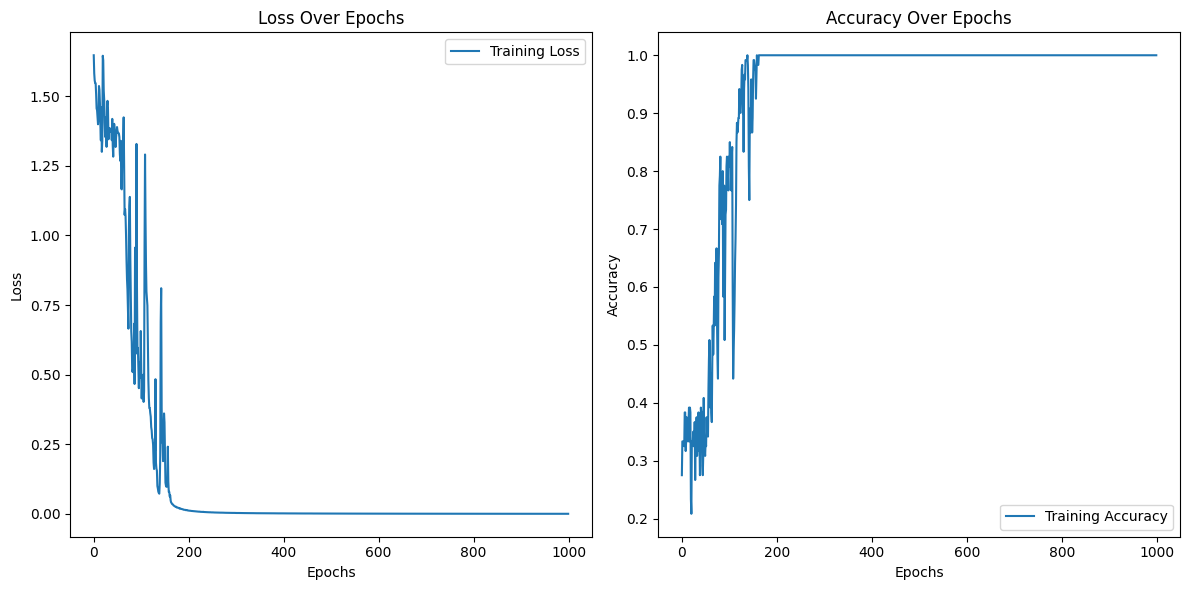

In [ ]:
# 绘制训练和验证损失
plt.figure(figsize=(12, 6))

# 绘制训练损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # 修改键名为 'accuracy'
if 'val_accuracy' in history.history:  # 修改验证准确率键名为 'val_accuracy'
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 保存模型的权重
model.save_weights('model_weights.h5')


ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 105, 528), found shape=(None, 105, 1662)


add in velocity and acceleartion

In [ ]:
def calculate_velocity_acceleration(data):
    """
    计算每个帧的速度和加速度。
    
    参数：
    - data: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组

    返回：
    - 带有速度和加速度特征的新数据，形状为 (num_samples, sequence_length, num_keypoints * 3)
    """
    # 计算速度
    velocity = np.diff(data, axis=1)  # 对每个时间步进行差分，得到速度
    velocity = np.concatenate([velocity[:, :1, :], velocity], axis=1)  # 保持与原始帧数量一致
    
    # 计算加速度
    acceleration = np.diff(velocity, axis=1)  # 对速度再进行差分，得到加速度
    acceleration = np.concatenate([acceleration[:, :1, :], acceleration], axis=1)  # 保持与原始帧数量一致
    
    return velocity, acceleration

def normalize_features(features):
    """
    对每个手语序列的速度或加速度进行标准化。
    
    参数：
    - features: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组 (速度或加速度)

    返回：
    - 归一化后的特征
    """
    mean = np.mean(features, axis=1, keepdims=True)
    std = np.std(features, axis=1, keepdims=True) + 1e-6  # 避免除以零
    normalized_features = (features - mean) / std
    return normalized_features

def calculate_relative_change(features):
    """
    计算每一帧相对于前一帧的相对变化量。
    
    参数：
    - features: 形状为 (num_samples, sequence_length, num_keypoints) 的 3D 数组 (归一化后的速度或加速度)

    返回：
    - 相对变化的特征
    """
    relative_change = np.diff(features, axis=1)
    relative_change = np.concatenate([relative_change[:, :1, :], relative_change], axis=1)  # 保持形状一致
    return relative_change

# 应用在你的数据上
velocity, acceleration = calculate_velocity_acceleration(X_centralized)
normalized_velocity = normalize_features(velocity)
normalized_acceleration = normalize_features(acceleration)

relative_velocity = calculate_relative_change(normalized_velocity)
relative_acceleration = calculate_relative_change(normalized_acceleration)

# 将原始数据、相对速度和相对加速度拼接
X_augmented = np.concatenate([X_centralized, relative_velocity, relative_acceleration], axis=-1)
print("X_augmented 的形状:", X_augmented.shape)
print("X_centralized 的形状:", X_centralized.shape)


X_augmented 的形状: (150, 105, 1584)
X_centralized 的形状: (150, 105, 528)


In [ ]:
y = to_categorical(labels, num_classes=len(words)).astype(int)

# 分割增强后的数据
X_augmented_train, X_augmented_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=42
)

# 确认分割后的数据形状
print("X_augmented_train shape:", X_augmented_train.shape)
print("X_augmented_test shape:", X_augmented_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_augmented_train shape: (120, 105, 1584)
X_augmented_test shape: (30, 105, 1584)
y_train shape: (120, 5)
y_test shape: (30, 5)


In [ ]:
model_with_velocity = Sequential()
# 使用 'tanh' 激活函数以便利用 cuDNN 优化
model_with_velocity.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(105, 1584)))
model_with_velocity.add(Dropout(0.2))
model_with_velocity.add(LSTM(64, return_sequences=True, activation='tanh'))
model_with_velocity.add(Dropout(0.2))
model_with_velocity.add(LSTM(32, activation='tanh'))
model_with_velocity.add(Dense(64))
model_with_velocity.add(LeakyReLU(alpha=0.1))
model_with_velocity.add(BatchNormalization())
model_with_velocity.add(Dense(32))
model_with_velocity.add(LeakyReLU(alpha=0.1))
model_with_velocity.add(BatchNormalization())
model_with_velocity.add(Dense(len(words), activation='softmax'))

# 编译模型，使用 'accuracy' 作为度量指标
model_with_velocity.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
log_dir_with_velocity = os.path.join('Logs', 'with_velocity')
tb_callback_with_velocity = TensorBoard(log_dir=log_dir_with_velocity)

# 定义 EarlyStopping 回调：当验证损失在 5 个 epoch 后没有改善时停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 定义 ReduceLROnPlateau 回调：如果验证损失连续 3 个 epoch 无改善则降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# 将回调函数放入列表中
callbacks = [tb_callback_with_velocity , early_stopping, reduce_lr]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model  # 这里确保导入了正确的模块
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint  # 确保此处名称无冲突
history = model_with_velocity.fit(X_augmented_train, y_train, epochs=200, callbacks=[tb_callback_with_velocity])

Epoch 1/200


TypeError: 'NoneType' object is not callable

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model  # 这里确保导入了正确的模块
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint  # 确保此处名称无冲突


# 定义权重保存路径
checkpoint_path = "I:/Ece496/custom_data/model_with_velocity_best_weights.h5"

# 设置 ModelCheckpoint 回调，监测训练损失以保存最佳权重
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',           # 使用训练损失作为监测指标
    save_best_only=True,      # 仅保存最佳权重
    save_weights_only=True,   # 仅保存权重而非整个模型
    mode='min',               # 寻找训练损失的最小值
    verbose=1                 # 输出保存信息
)

# 训练模型时使用回调
history = model_with_velocity.fit(
    X_train, 
    y_train, 
    epochs=200, 
    callbacks=[checkpoint_callback],
    validation_data=(X_test, y_test)  # 使用测试集作为评估
)


Epoch 1/200


ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\anaconda3\envs\tf2x_clone\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 105, 1584), found shape=(None, 105, 528)
